# Feature extraction for SVM

### Imports

In [ ]:
from google.colab import drive

import os

import torchvision.transforms as transforms
import torchvision.models as models
import torch
from torch import nn

import gc

from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### Mounting Google Drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

# Define the root folder paths
GDrivePath = '/content/drive/MyDrive/'

# Specify the folder path
#folderpath = GDrivePath + 'Colab Notebooks/CVPR2023/Progetto_CV&PR_Finale/'
folderpath = GDrivePath + 'Colab Notebooks/Computer Vision & Pattern Recognition/Progetto_CV&PR_Finale/'

# Define folder paths for train and test images
train_filepath = folderpath + 'train/'
test_filepath = folderpath + 'test/'

Mounted at /content/drive/


### Import some modules made by us

In [ ]:
# Change directory
os.chdir(folderpath)
!pwd

/content/drive/MyDrive/Colab Notebooks/Computer Vision & Pattern Recognition/Progetto_CV&PR_Finale


In [ ]:
from datasets_utilities import show_images, load_images_from_folder
from training_utilities import class_mapping

## Dataloaders initialization (AlexNet)

In [ ]:
# Transforms adapted for Alexnet
transform_AlexNet = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert image to RGB
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize tensors according to community standards
])

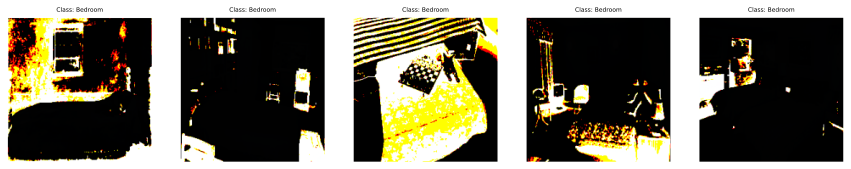

In [ ]:
batch_size = 32

# Load train and test images with the Alexnet transform
train_set, train_labels = load_images_from_folder(train_filepath, transform_AlexNet)
test_set, test_labels = load_images_from_folder(test_filepath, transform_AlexNet)

show_images(train_set, train_labels)

# Create PyTorch datasets
train_set = torch.utils.data.TensorDataset(torch.stack(train_set), torch.tensor(train_labels))
test_set = torch.utils.data.TensorDataset(torch.stack(test_set), torch.tensor(test_labels))

# Create DataLoader
train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

### Load and adapt AlexNet

In [ ]:
# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Remove the last fully connected layer (classification layer)
alexnet_intermediate = nn.Sequential(*list(alexnet.children())[:-1])

# Set the model to evaluation mode
alexnet_intermediate.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:06<00:00, 38.8MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
)

### Feature extraction for SVM

In [ ]:
# Function that uses AlexNet to extrat features from images
def extract_features(data_loader):
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Extract features from the intermediate layer
            intermediate_output = alexnet_intermediate(inputs)

            features.append(intermediate_output)
            labels.append(targets)

    features = torch.cat(features, dim=0) # Concatenate the sequence of tensors along the given dimension
    labels = torch.cat(labels, dim=0)

    return features, labels

In [ ]:
# Extract features
train_features, train_labels = extract_features(train_set)
test_features, test_labels = extract_features(test_set)

# Flatten features
flattened_train_features = train_features.view(train_features.size(0), -1)
flattened_test_features = test_features.view(test_features.size(0), -1)

# Free memory
train_set = None
test_set = None
gc.collect()

12170

### Classifiers definition and training

In [ ]:
def exp_4_with_kernel_ovo(kernel):
    ovo_classifier = OneVsOneClassifier(SVC(kernel = kernel))
    ovo_classifier.fit(flattened_train_features, train_labels)
    ovo_predictions = ovo_classifier.predict(flattened_test_features)
    ovo_accuracy = accuracy_score(test_labels, ovo_predictions)
    print('For ' + kernel + " kernel:")
    print('OVO accuracy => {:.2f}%'.format(ovo_accuracy * 100))
    return ovo_accuracy

def exp_4_with_kernel_ovr(kernel):
    ovr_classifier = OneVsRestClassifier(SVC(kernel = kernel))
    ovr_classifier.fit(flattened_train_features, train_labels)
    ovr_predictions = ovr_classifier.predict(flattened_test_features)
    ovr_accuracy = accuracy_score(test_labels, ovr_predictions)
    print('For ' + kernel + " kernel:")
    print('OVR accuracy => {:.2f}%'.format(ovr_accuracy * 100))
    return ovr_accuracy

def exp_4_with_kernel_ecoc(kernel):
    ecoc_classifier = OutputCodeClassifier(SVC(kernel = kernel))
    ecoc_classifier.fit(flattened_train_features, train_labels)
    ecoc_predictions = ecoc_classifier.predict(flattened_test_features)
    ecoc_accuracy = accuracy_score(test_labels, ecoc_predictions)
    print('For ' + kernel + " kernel:")
    print('ECOC accuracy => {:.2f}%'.format(ecoc_accuracy * 100))
    return ecoc_accuracy

#### Testing some kernels and classifiers

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

results_df = pd.DataFrame()

for kernel_ in kernels:
    results_df['{}_ovo'.format(kernel_)] = [exp_4_with_kernel_ovo(kernel_)]
    results_df['{}_ovr'.format(kernel_)] = [exp_4_with_kernel_ovr(kernel_)]
    results_df['{}_ecoc'.format(kernel_)] = [exp_4_with_kernel_ecoc(kernel_)]

results_df.to_csv('exp_4.csv', index=False)

### Testing the best model and printint Confusion Matrix

For sigmoid kernel:
OVO accuracy => 87.17%
Confusion Matrix:


<Axes: title={'center': 'Test-set Confusion Matrix'}>

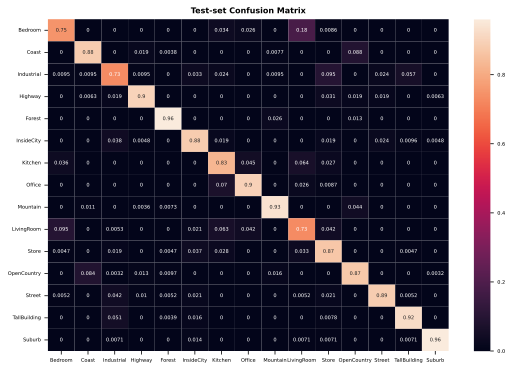

In [ ]:
# best model found => OVO with sigmoid kernel

ovo_classifier = OneVsOneClassifier(SVC(kernel = 'sigmoid'))
ovo_classifier.fit(flattened_train_features, train_labels)
ovo_predictions = ovo_classifier.predict(flattened_test_features)
ovo_accuracy = accuracy_score(test_labels, ovo_predictions)
print('For sigmoid kernel:')
print('OVO accuracy => {:.2f}%'.format(ovo_accuracy * 100))

print('Confusion Matrix:')
classes=list(class_mapping.keys())
cf_matrix = confusion_matrix(test_labels, ovo_predictions) # Calculate confusion matrix
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (9,6))
plt.title("Test-set Confusion Matrix", fontsize=8, fontweight='bold')
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')